## Initial comparison 

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
os.listdir('.')

['.ipynb_checkpoints',
 'custom_attention.py',
 'longformer-base-512-text-classification-emotion-adamw-att_win_size_128-epochs-7',
 'longformer-base-512-text-classification-emotion-adamw-att_win_size_16-epochs-7',
 'longformer-base-512-text-classification-emotion-adamw-att_win_size_256-epochs-7',
 'longformer-base-512-text-classification-emotion-adamw-att_win_size_32-epochs-7',
 'longformer-base-512-text-classification-emotion-adamw-att_win_size_64-epochs-7',
 'longformer-base-512-text-classification-imdb-adamw-att_win_size_128-epochs-5',
 'longformer-base-512-text-classification-imdb-adamw-att_win_size_128-epochs-7',
 'longformer-base-512-text-classification-imdb-adamw-att_win_size_16-epochs-5',
 'longformer-base-512-text-classification-imdb-adamw-att_win_size_16-epochs-7',
 'longformer-base-512-text-classification-imdb-adamw-att_win_size_256-epochs-5',
 'longformer-base-512-text-classification-imdb-adamw-att_win_size_256-epochs-7',
 'longformer-base-512-text-classification-imdb-adamw

In [42]:
def extract_att_win_size(folder_name, contain):
    if 'roberta' in folder_name:
        return 512
    if contain == 'emotion':
        return int(folder_name.split('_')[-1])
    else:
        return int(folder_name.split('_')[-1].split('-')[0])

def plot_data(contain, metric):
    subfolders = [f.path for f in os.scandir('.') if f.is_dir() and contain in f.path]
    subfolders = sorted(subfolders, key=lambda x: extract_att_win_size(x, contain))

    if contain == 'epochs-7':
        subfolders = [x for x in subfolders if 'emotion' not in x]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 6))
    axes = axes.flatten()

    for idx, subfolder in enumerate(subfolders):
        with open(os.path.join(subfolder, 'summary.json'), 'r') as f:
            summary = json.load(f)
        
        with open(os.path.join(subfolder, 'test_results.json'), 'r') as f:
            test_results = json.load(f)
        
        train_losses = pd.read_csv(os.path.join(subfolder, 'train_losses.csv'))
        val_losses = pd.read_csv(os.path.join(subfolder, 'val_losses.csv'))
        
        att_win_size = extract_att_win_size(subfolder, contain)
        
        axes[idx].plot(train_losses['epoch'], train_losses['train_' + metric], label='Train '+ metric)
        axes[idx].plot(val_losses['epoch'], val_losses['eval_' + metric], label='Validation ' + metric)

        if att_win_size == 512:
            att_win_size = 'n^2'
        main_title = f"Attention Window Size: {att_win_size}"
        subtitle = (f"Test {metric}: {test_results['test_' + metric]:.3f}, Samples/sec: {summary['samples/sec']:.2f}, "
                    f"GPU Memory: {summary['gpu_memory']} MB")
        
        axes[idx].set_title(main_title, fontsize=14, pad=20)
        axes[idx].text(0.5, 1.05, subtitle, ha='center', va='center', transform=axes[idx].transAxes, fontsize=10, alpha=0.9)
        
        if metric == 'loss':
            axes[idx].set_ylim(0,0.7)
        else:
            axes[idx].set_ylim(0.7,1)
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel(metric.capitalize())
        axes[idx].legend()
    dataset = subfolder.split('-')[5]
    fig.suptitle(f'Dataset: {dataset}', fontsize=16)

    plt.tight_layout(pad=1)
    plt.show()

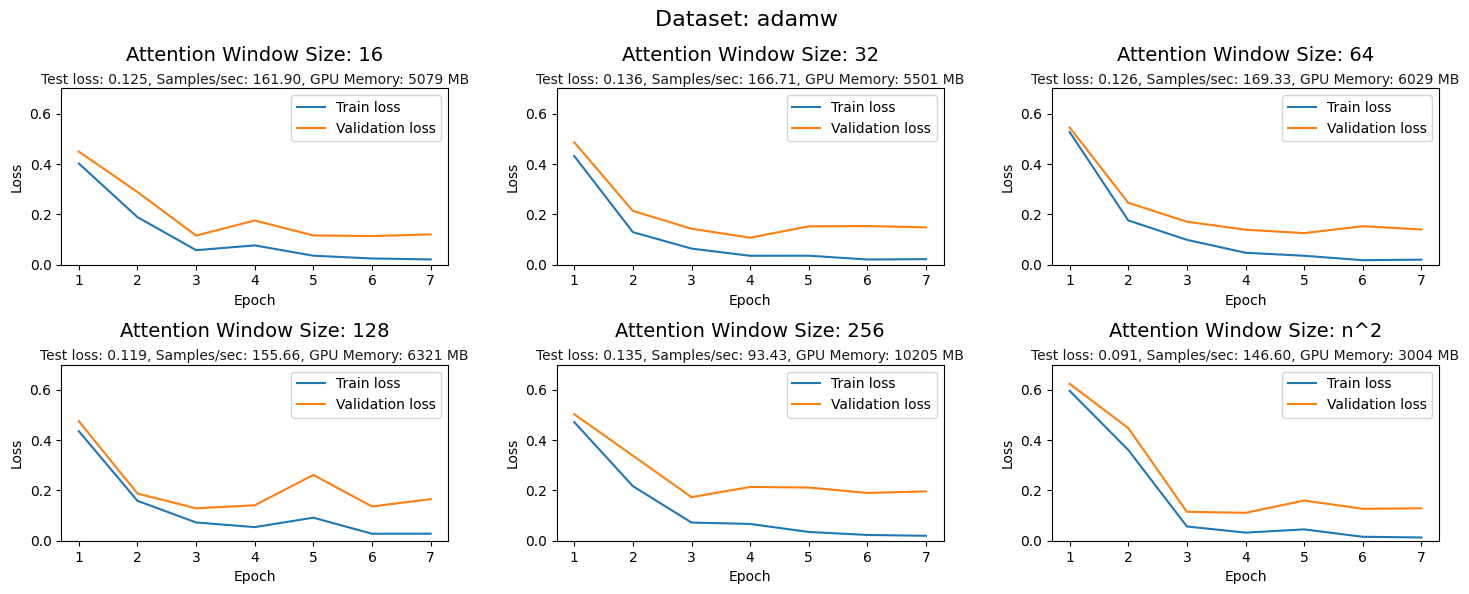

In [43]:
plot_data('emotion', 'loss')

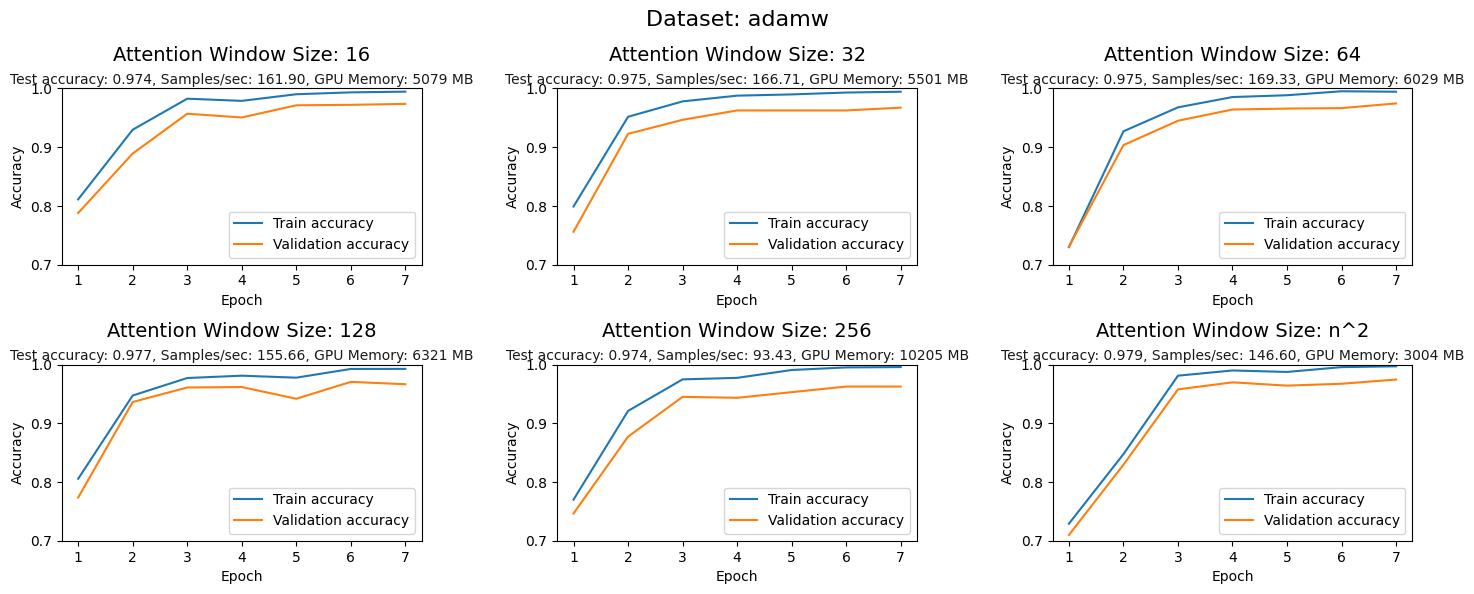

In [44]:
plot_data('emotion', 'accuracy')

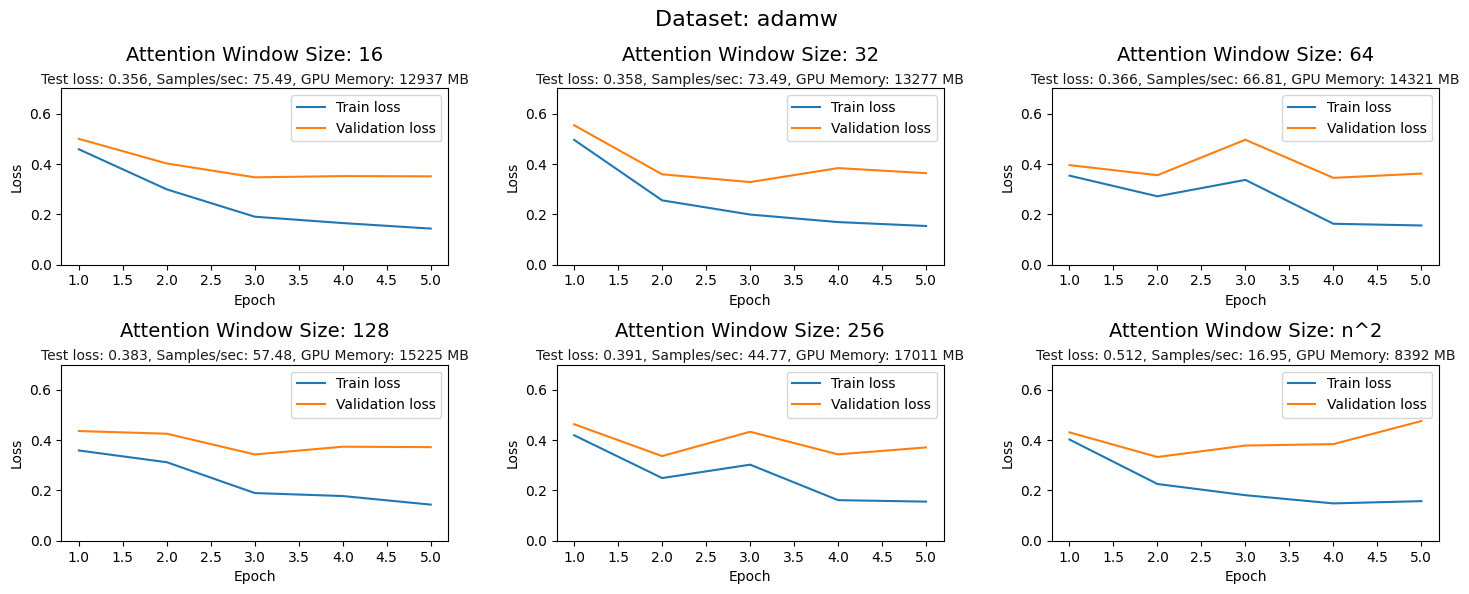

In [45]:
plot_data('epochs-5', 'loss')

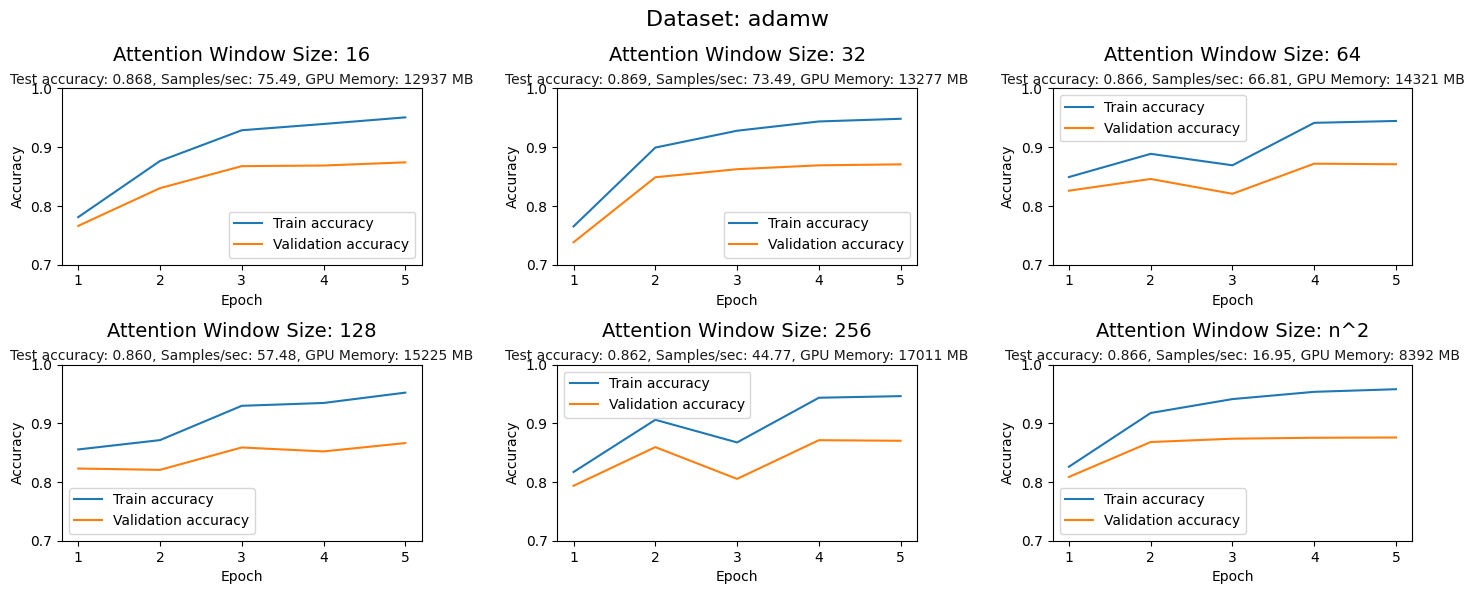

In [46]:
plot_data('epochs-5', 'accuracy')

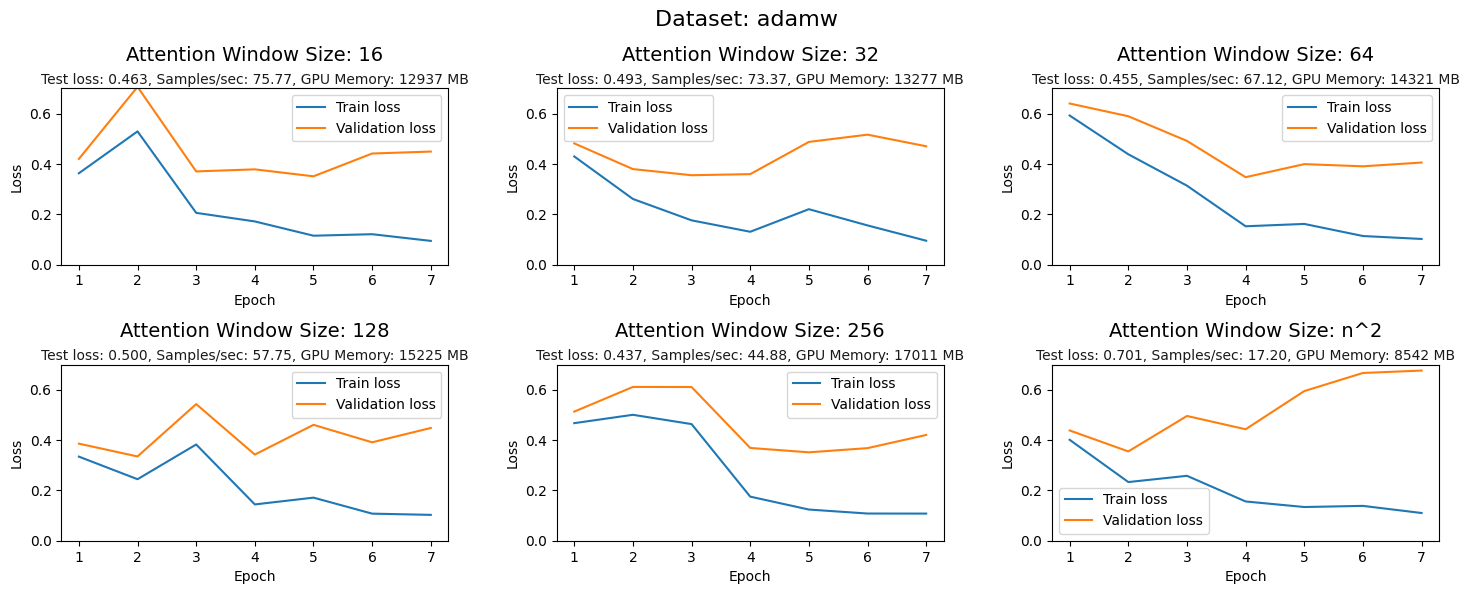

In [47]:
plot_data('epochs-7', 'loss')

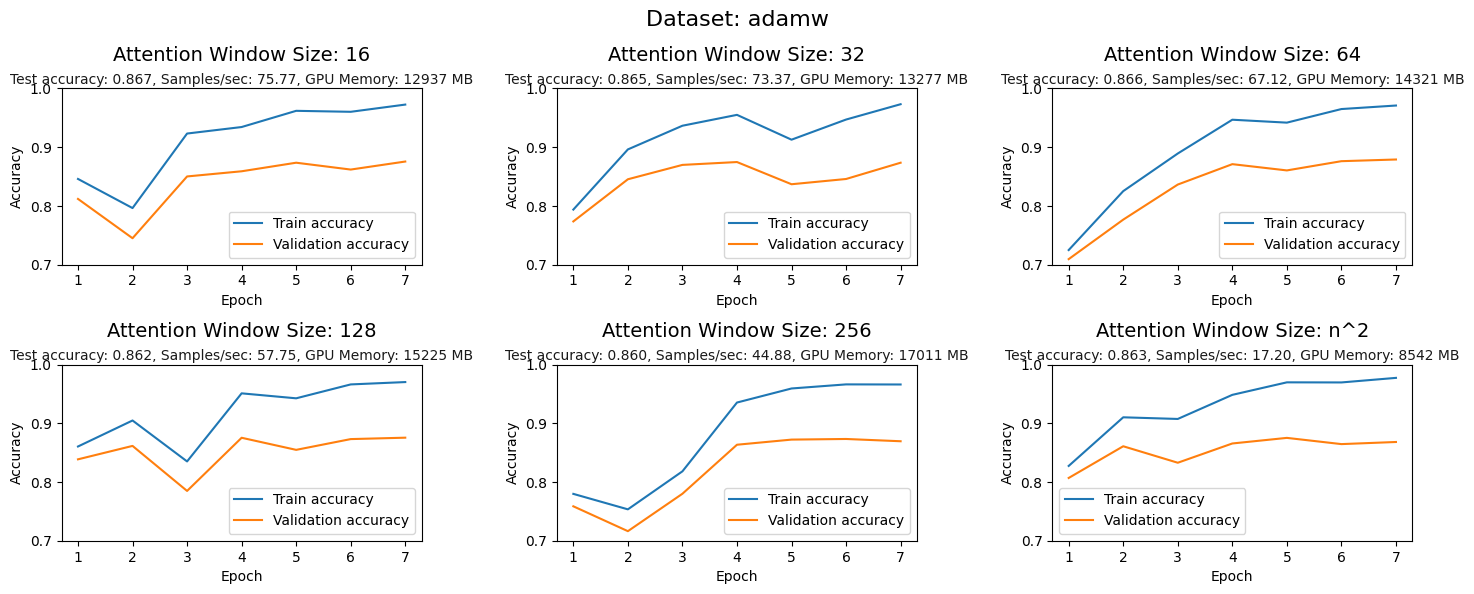

In [48]:
plot_data('epochs-7', 'accuracy')

### Training process AdamW

In [12]:
def plot_comparinson_global(contain, metric):
    if isinstance(contain, str):
        contain = [contain]

    subfolders = [f.path for f in os.scandir('.') if f.is_dir() and all(c in f.path for c in contain)]
    subfolders = sorted(subfolders, key=lambda x: extract_att_win_size(x, contain))

    subfolders_with_global = [sf for sf in subfolders if 'no_global' not in sf]
    subfolders_without_global = [sf for sf in subfolders if 'no_global' in sf]

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    ax_no_global, ax_with_no_global = axes

    def plot_subfolders(subfolders, ax, title):
        for subfolder in subfolders:
            with open(os.path.join(subfolder, 'summary.json'), 'r') as f:
                summary = json.load(f)
            
            with open(os.path.join(subfolder, 'test_results.json'), 'r') as f:
                test_results = json.load(f)
            
            train_losses = pd.read_csv(os.path.join(subfolder, 'train_losses.csv'))
            val_losses = pd.read_csv(os.path.join(subfolder, 'val_losses.csv'))
            
            att_win_size = extract_att_win_size(subfolder, contain)
            
            ax.plot(train_losses['epoch'], train_losses['train_' + metric], label=f'Train {metric}, Attn {att_win_size}')
            ax.plot(val_losses['epoch'], val_losses['eval_' + metric], label=f'Val {metric}, Attn {att_win_size}')

        ax.set_title(title)
        ax.set_xlabel('Epoch')
        ax.set_ylim(0, 0.8)
        ax.set_ylabel(metric.capitalize())
        ax.legend()

    plot_subfolders(subfolders_with_global, ax_no_global, 'Subfolders with global')
    plot_subfolders(subfolders_without_global, ax_with_no_global, 'Subfolders without global')

    if subfolders:
        dataset = subfolders[0].split('-')[5]
        fig.suptitle(f'Dataset: {dataset}', fontsize=16)

    plt.tight_layout(pad=1)
    plt.show()

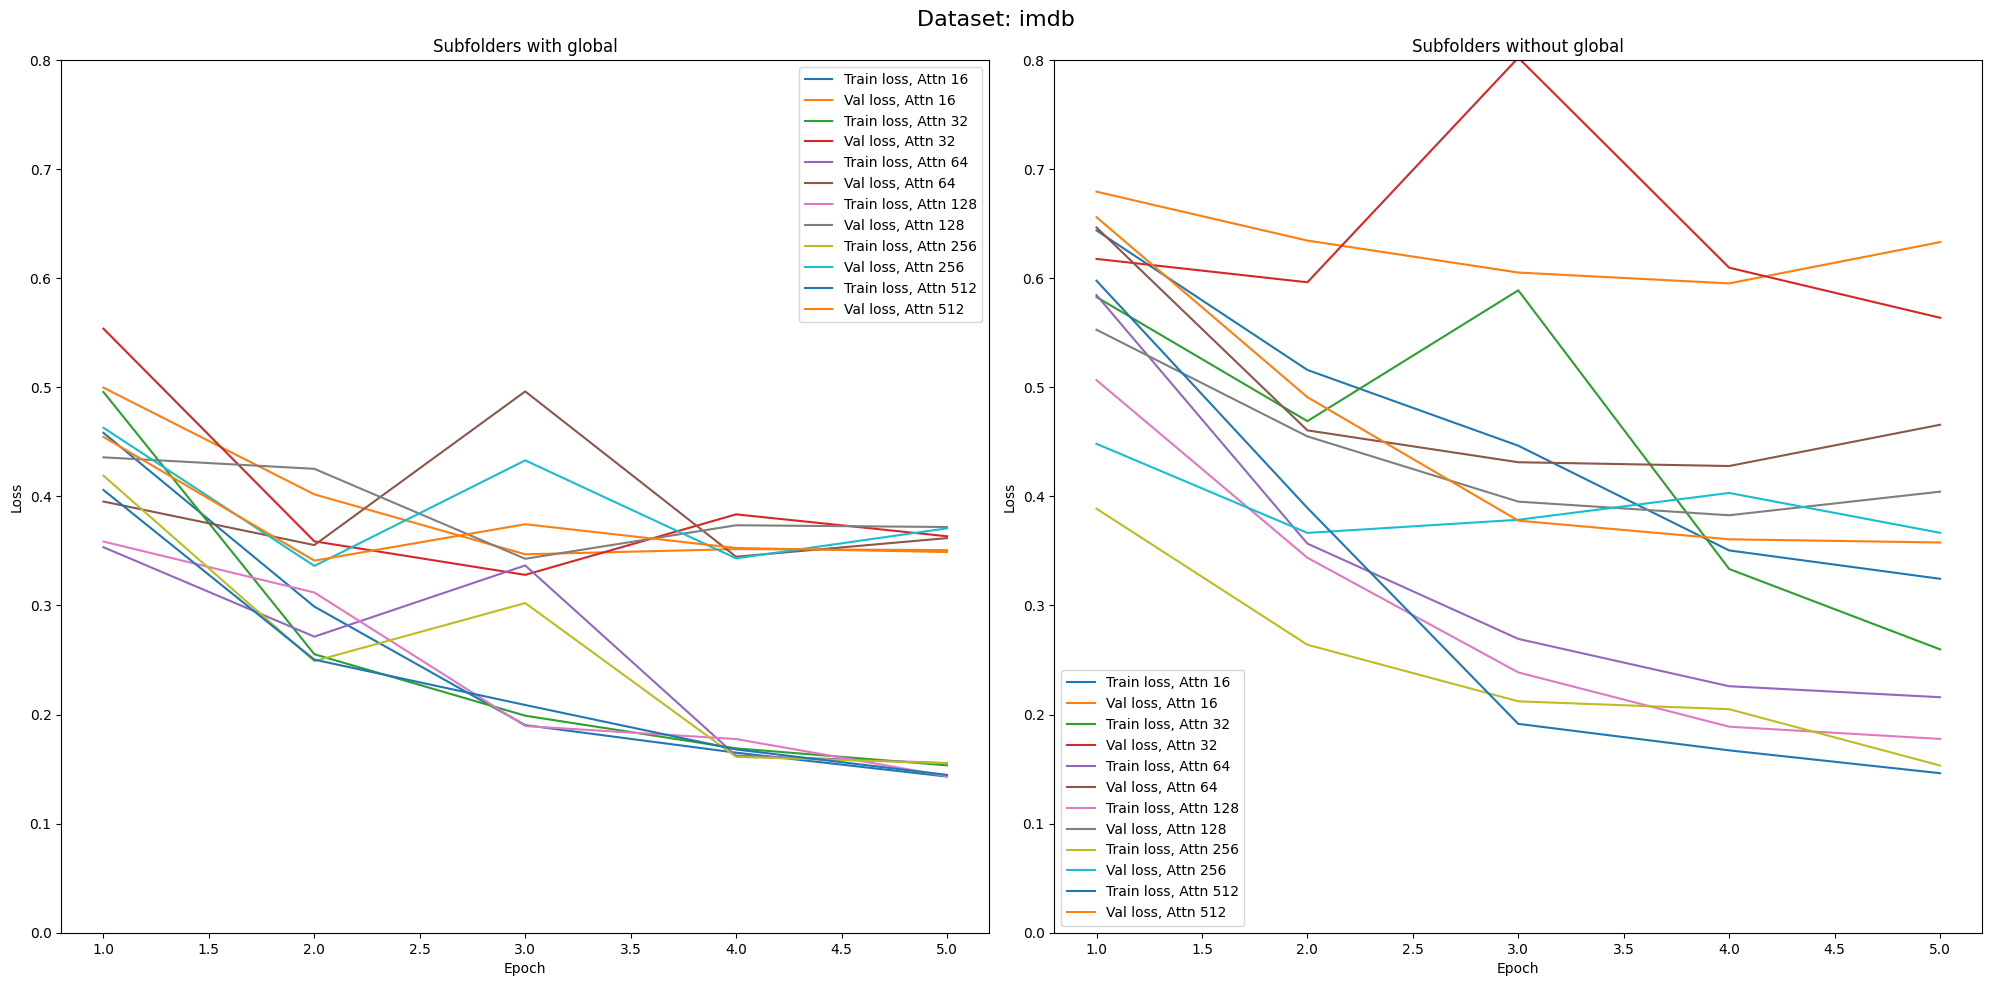

In [15]:
plot_comparinson_global(['imdb', 'epochs-5'], 'loss')

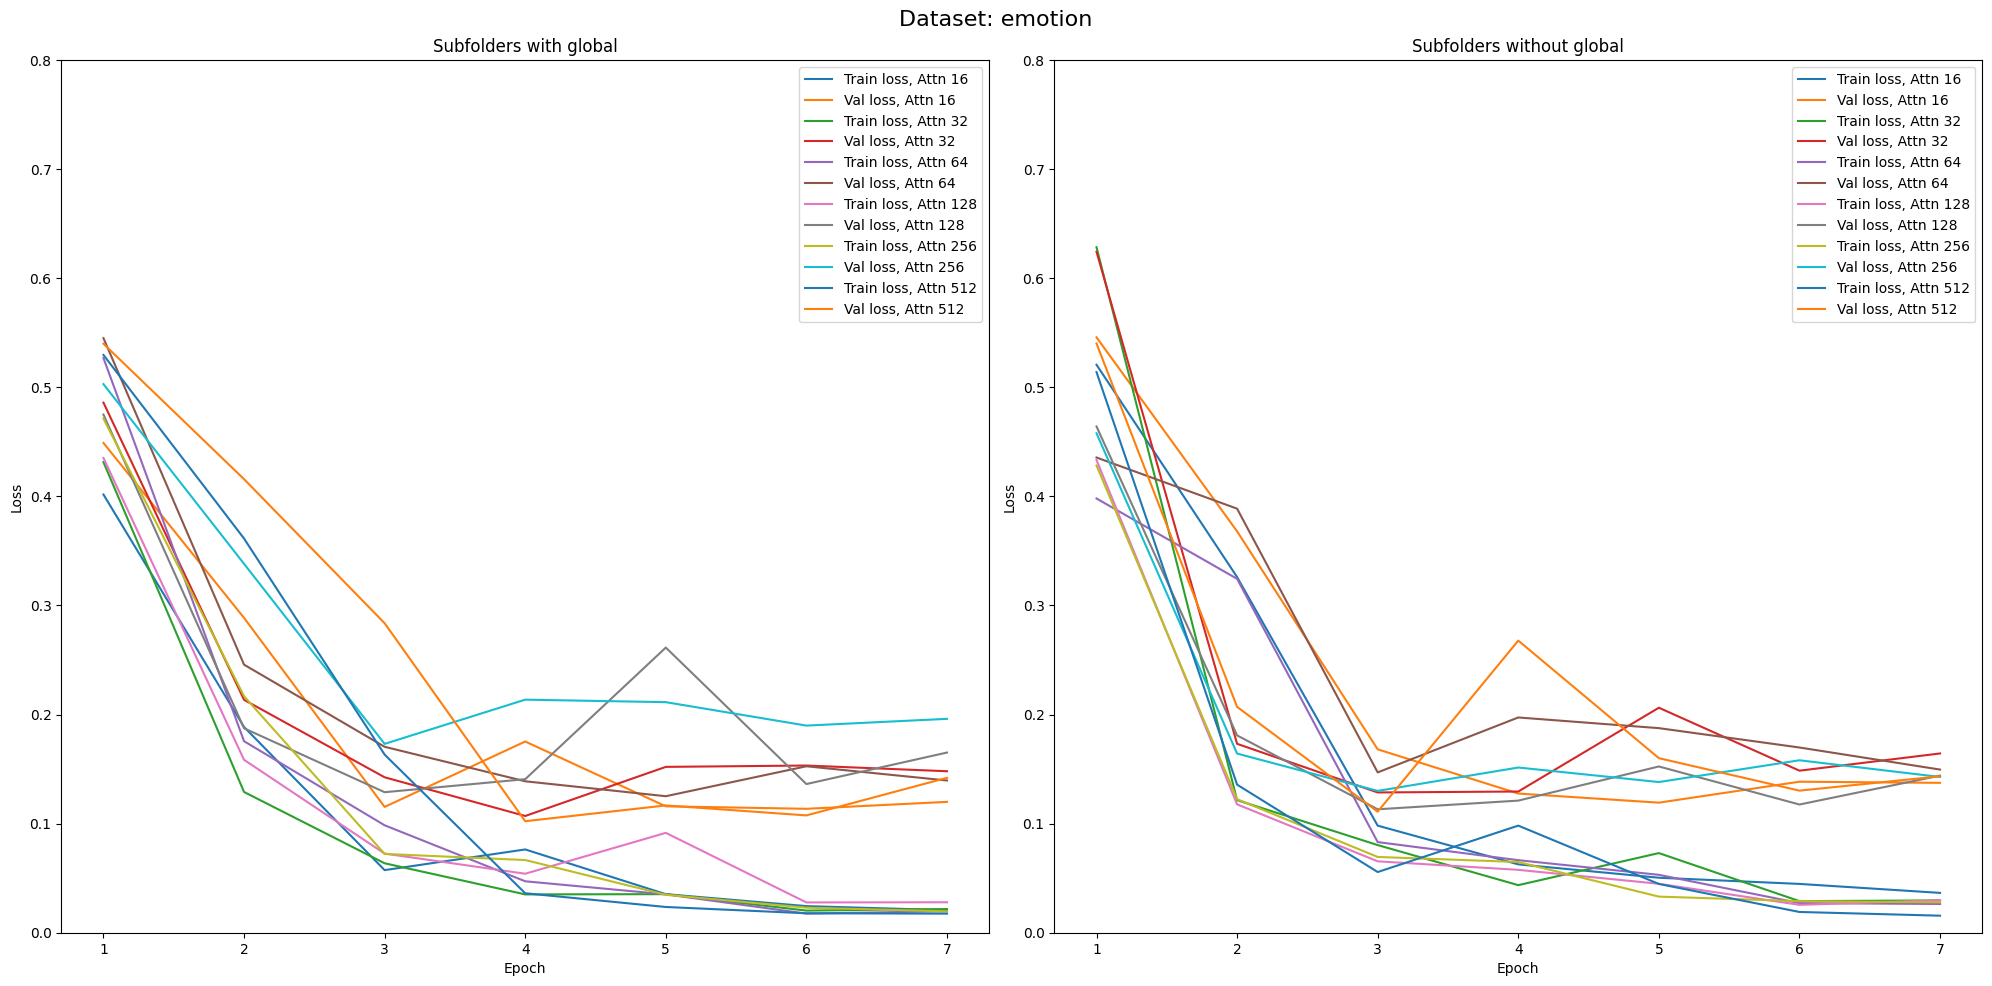

In [14]:
plot_comparinson_global(['emotion', 'epochs-7'], 'loss')

In [16]:
def plot_training_process(contain, metric):
    if isinstance(contain, str):
        contain = [contain]

    subfolders = [f.path for f in os.scandir('.') if f.is_dir() and all(c in f.path for c in contain)]
    subfolders = sorted(subfolders, key=lambda x: extract_att_win_size(x, contain))

    subfolders_with_global = [sf for sf in subfolders if 'no_global' not in sf]
    subfolders_without_global = [sf for sf in subfolders if 'no_global' in sf]

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for idx, subfolder in enumerate(zip(subfolders_with_global, subfolders_without_global)):
        subfolder_global, subfolder_without_global = subfolder
        train_res_global = pd.read_csv(os.path.join(subfolder_global, 'train_losses.csv'))
        val_res_global = pd.read_csv(os.path.join(subfolder_global, 'val_losses.csv'))
        train_res_wo_global = pd.read_csv(os.path.join(subfolder_without_global, 'train_losses.csv'))
        val_res_wo_global = pd.read_csv(os.path.join(subfolder_without_global, 'val_losses.csv'))
        
        att_win_size = extract_att_win_size(subfolder_global, contain)
        
        axes[idx].plot(train_res_global['epoch'], train_res_global['train_' + metric], label=f'Train with global')
        axes[idx].plot(val_res_global['epoch'], val_res_global['eval_' + metric], label=f'Val with global')
        axes[idx].plot(train_res_wo_global['epoch'], train_res_wo_global['train_' + metric], label=f'Train without global')
        axes[idx].plot(val_res_wo_global['epoch'], val_res_wo_global['eval_' + metric], label=f'Val without global')
        title = f"Attention Window Size: {att_win_size}"
        axes[idx].set_title(title, fontsize=15)
        axes[idx].set_xlabel('Epoch')
        if metric == 'loss':
            axes[idx].set_ylim(0, 0.85)
        else:
            axes[idx].set_ylim(0.5, 1)
        axes[idx].set_ylabel(metric.capitalize())
        axes[idx].legend()

    dataset = subfolders[0].split('-')[5]
    fig.suptitle(f'Dataset: {dataset}', fontsize=20)

    plt.tight_layout(pad=1)
    plt.show()

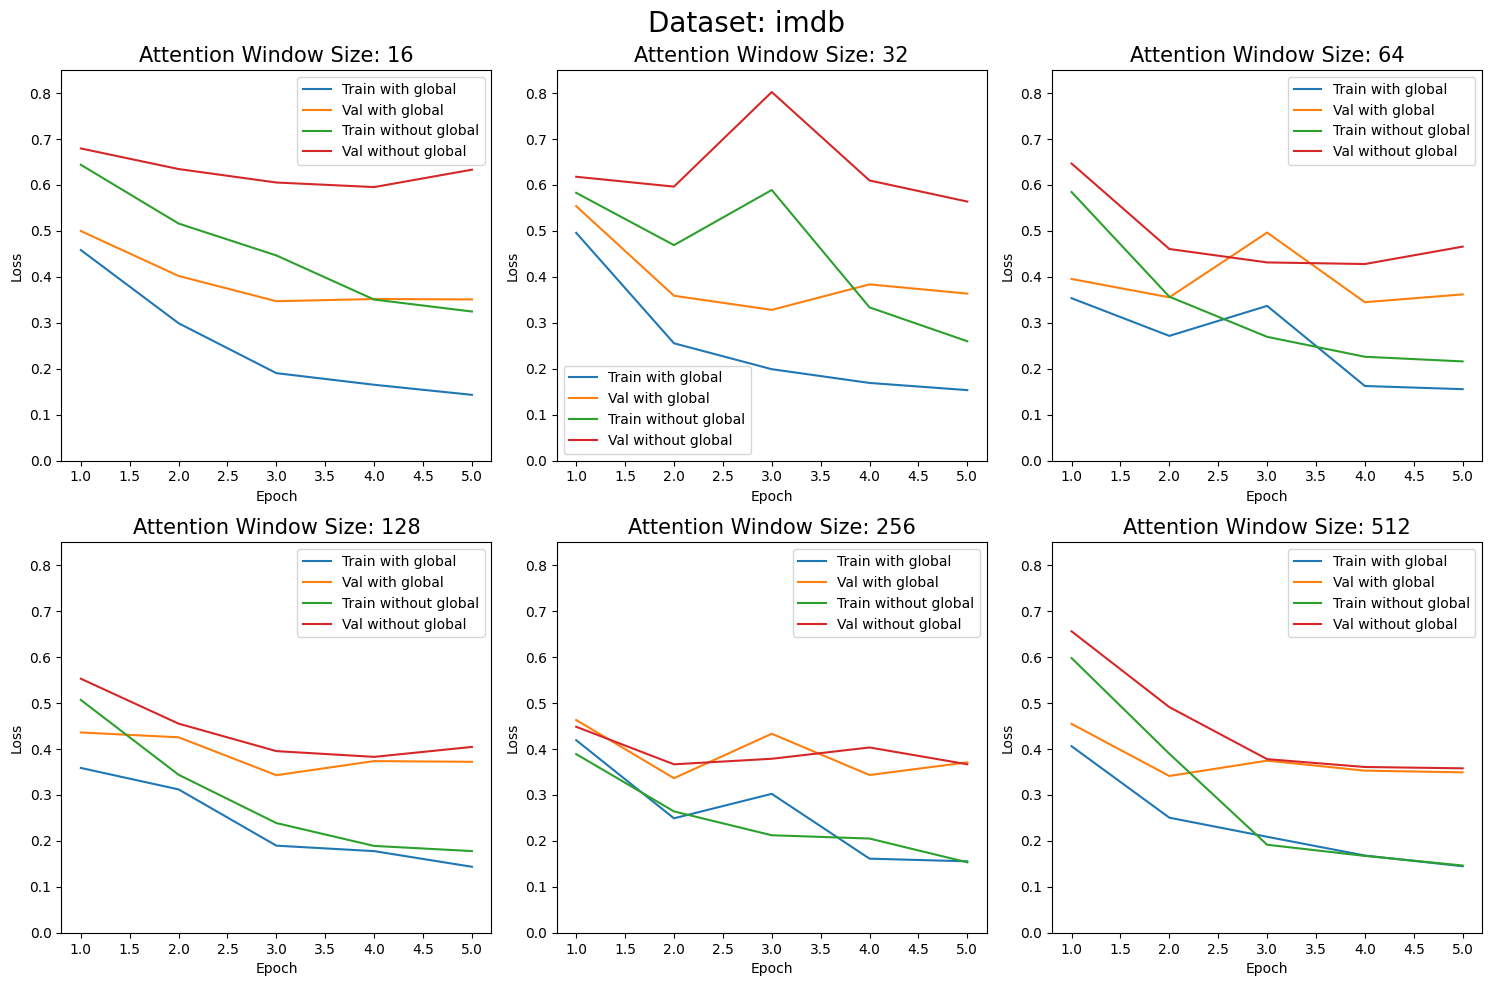

In [17]:
plot_training_process(['imdb', 'epochs-5'], 'loss')

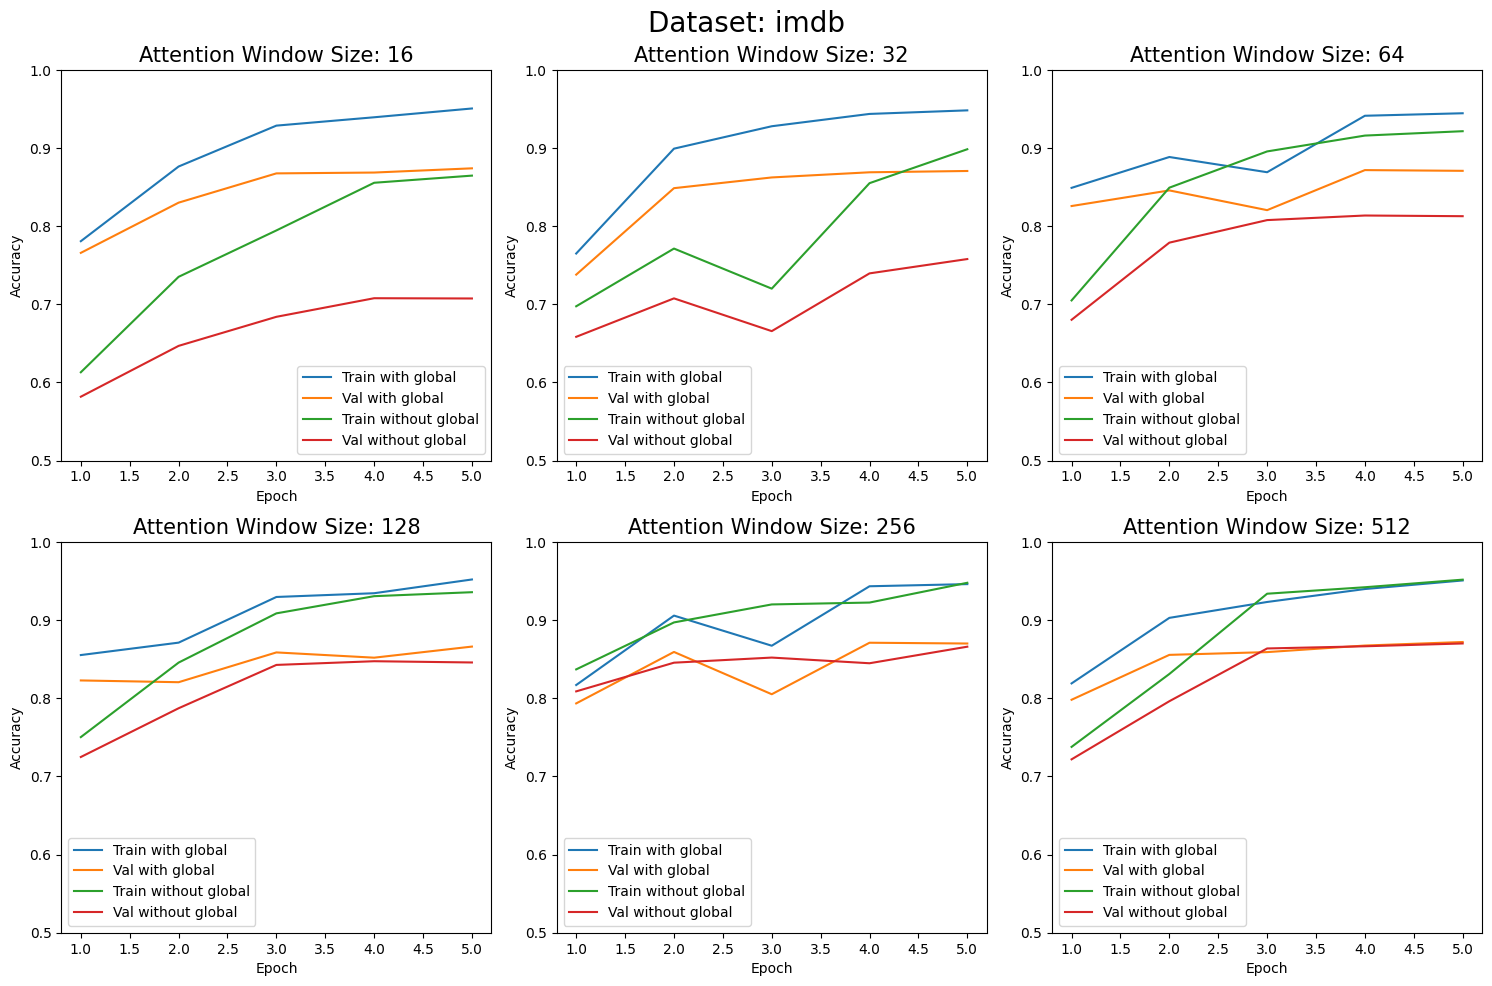

In [18]:
plot_training_process(['imdb', 'epochs-5'], 'accuracy')

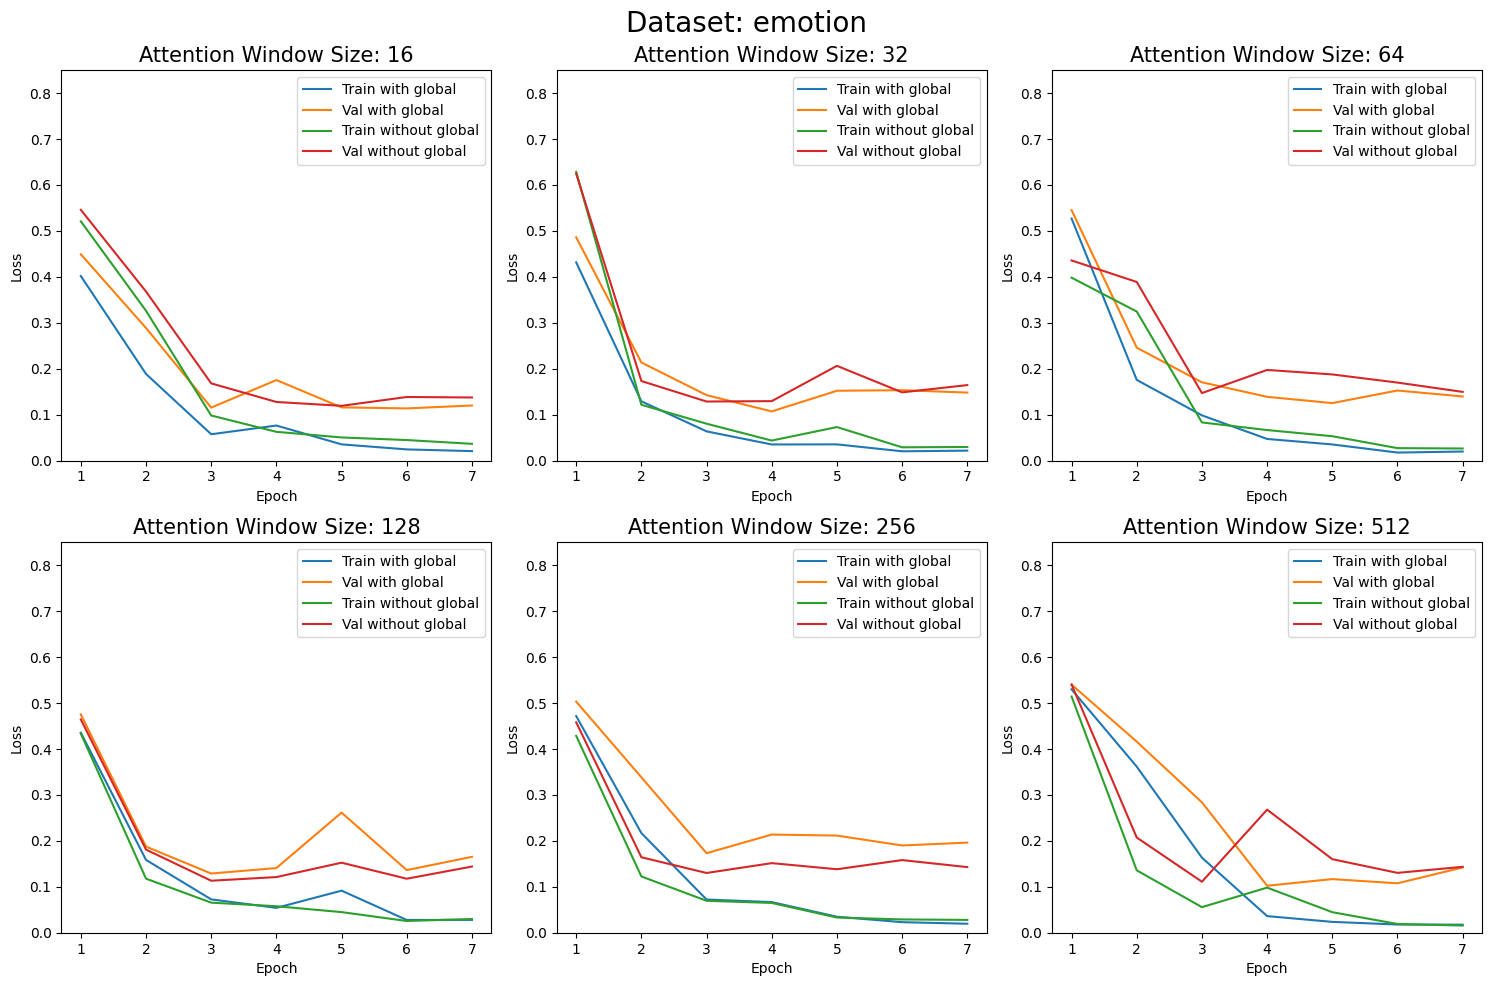

In [19]:
plot_training_process(['emotion', 'epochs-7'], 'loss')

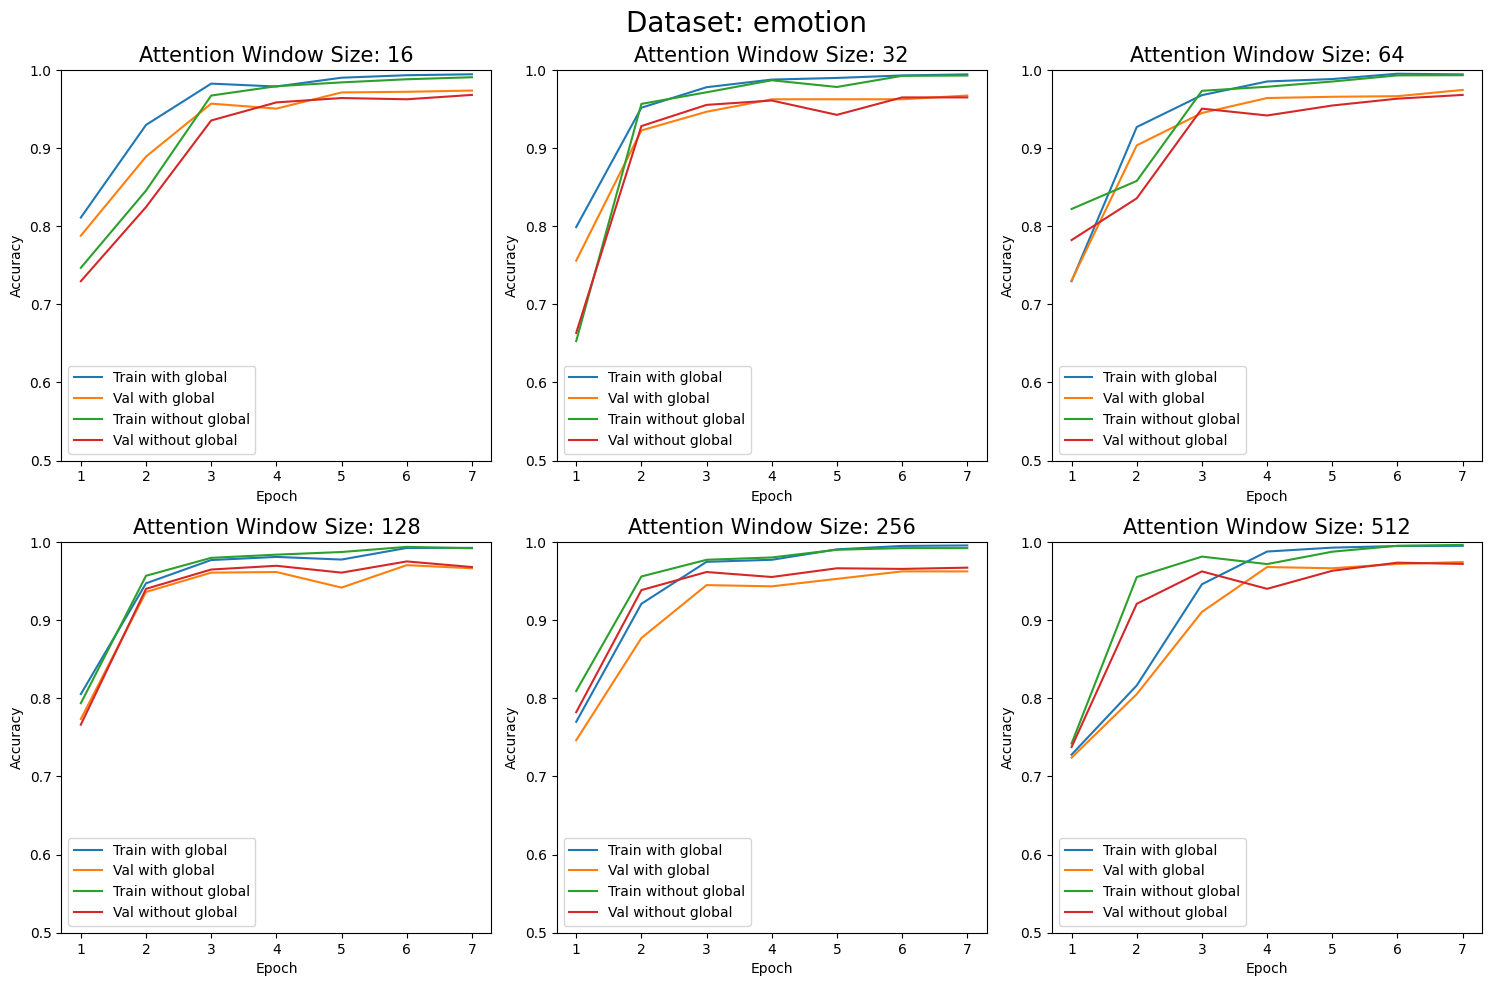

In [20]:
plot_training_process(['emotion', 'epochs-7'], 'accuracy')

# Comparison after running all trainings
- Adam, AdamW SGD
- sliding attention, sliding + sparse attention

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_statistics(dataset_name, metric, dataset_samples={}):
    df = pd.read_csv('extracted_features.csv')
    filtered_df = df[df['Dataset'] == dataset_name]
    
    attention_types = filtered_df['Attention Type'].unique()
    optimizers = filtered_df['Optimizer'].unique()

    window_sizes = sorted(filtered_df['Window Size'].unique())

    fig, ax = plt.subplots(figsize=(10, 6))
    for att_type in attention_types:
        for opt in optimizers:
            subset_df = filtered_df[(filtered_df['Attention Type'] == att_type) & (filtered_df['Optimizer'] == opt)]
            res = subset_df.set_index('Window Size')[metric].reindex(window_sizes)
            ax.plot(window_sizes, res, marker='o', linestyle='-', label=f'{opt}, {att_type}')
    
    ax.set_xlabel('Attention Window Size')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} vs Attention Window Size on {dataset_name} Dataset')
    ax.legend()
    
    plt.tight_layout(pad=1)
    plt.show()

## Memory Usage

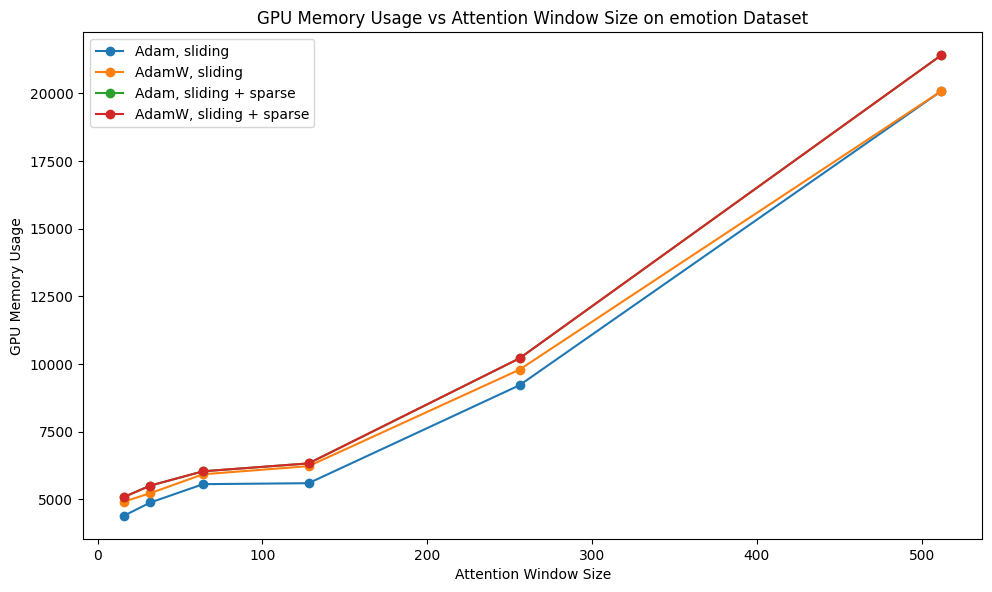

In [18]:
plot_statistics('emotion', 'GPU Memory Usage')

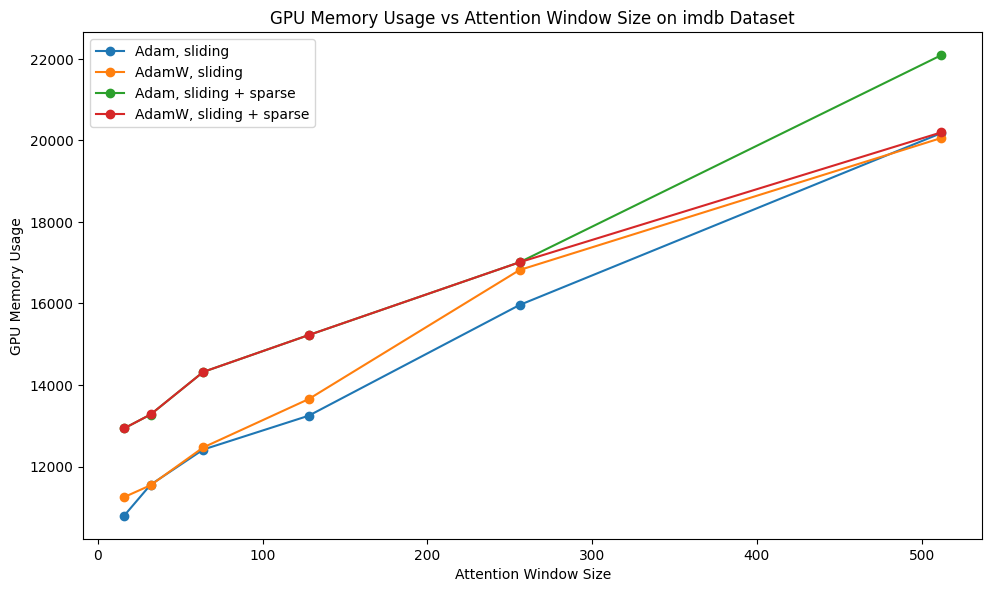

In [19]:
plot_statistics('imdb', 'GPU Memory Usage')

## Training Time

In [35]:
from datasets import Dataset, load_dataset
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

def stratified_split(dataset, n_samples):
    df = dataset.to_pandas()
    df_0 = df[df["label"] == 0]
    df_1 = df[df["label"] == 1]

    sample_0, _ = train_test_split(
        df_0, train_size=n_samples // 2, stratify=df_0["label"], random_state=42
    )
    sample_1, _ = train_test_split(
        df_1, train_size=n_samples // 2, stratify=df_1["label"], random_state=42
    )

    sample = pd.concat([sample_0, sample_1])
    remaining = df.drop(sample.index)

    return Dataset.from_pandas(sample), Dataset.from_pandas(remaining)

def filter_labels(example):
    return example["label"] in [0, 1]
    
def count_no_samples():
    dataset_samples = {}
    
    name = "imdb"
    dataset = load_dataset(name)
    _, new_train = stratified_split(dataset['train'], 7500)
    dataset_samples[name] = len(new_train)

    name = "emotion"
    dataset = load_dataset('dair-ai/' + name)
    dataset_samples[name] = len(dataset["train"].filter(filter_labels))
    
    return dataset_samples

dataset_samples = count_no_samples()
dataset_samples

{'imdb': 17500, 'emotion': 10028}

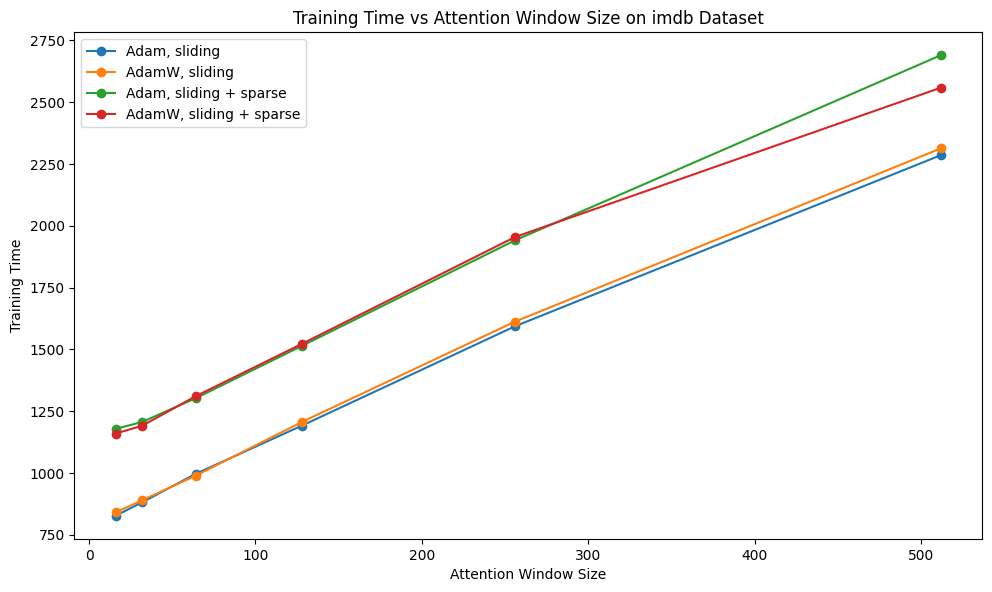

In [39]:
plot_statistics('imdb', 'Training Time', dataset_samples)

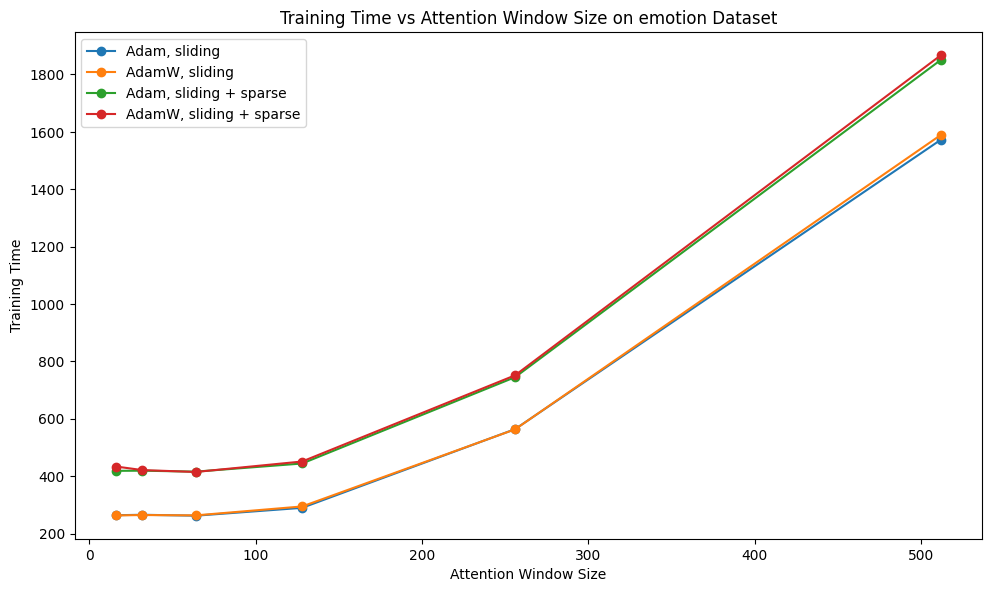

In [40]:
plot_statistics('emotion', 'Training Time', dataset_samples)

## Test Accuracy

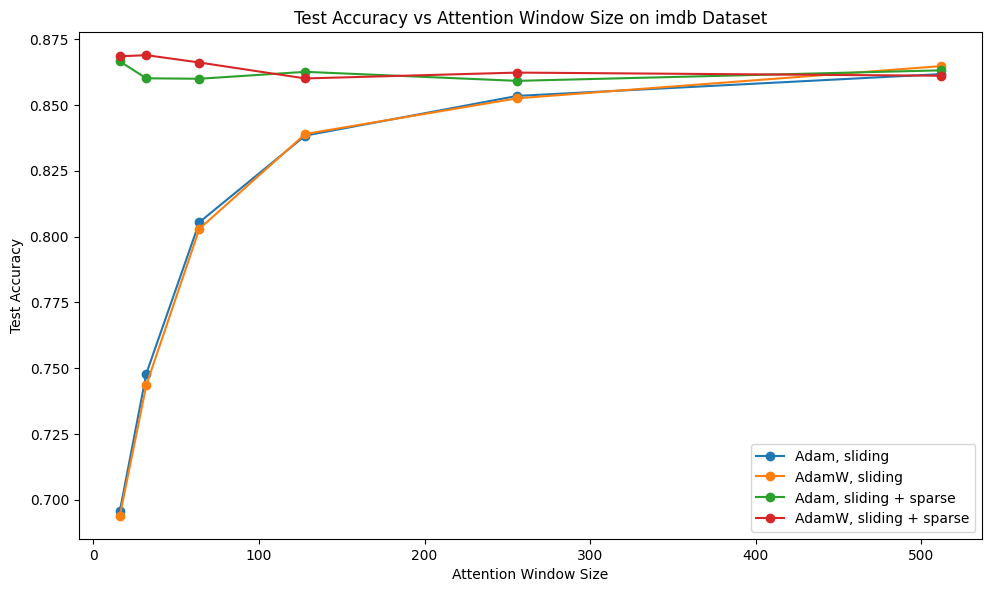

In [22]:
plot_statistics('imdb', 'Test Accuracy')

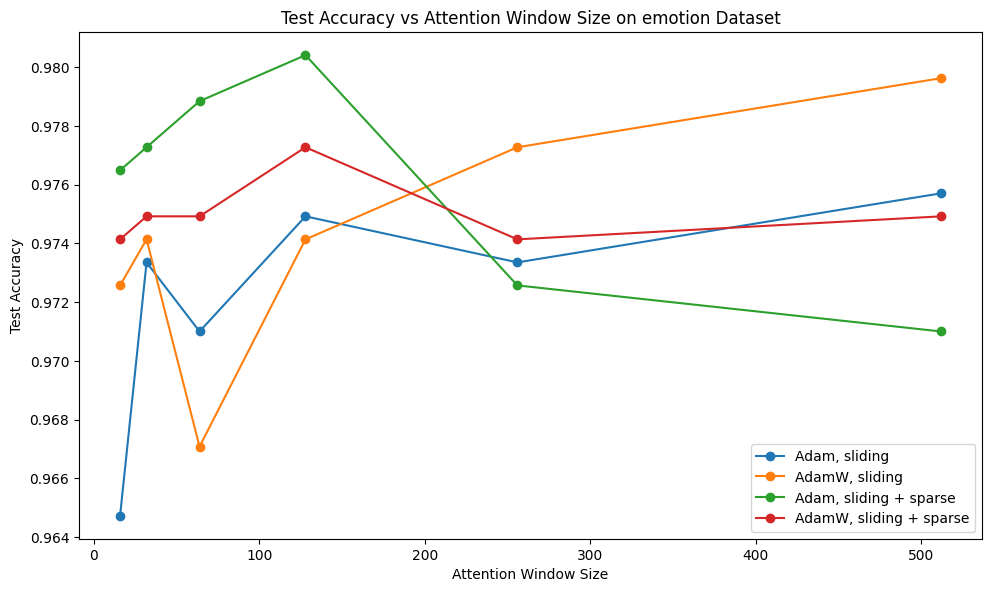

In [20]:
plot_statistics('emotion', 'Test Accuracy')